# Step8 演習06 ニューラルネットワークの実装
---

本演習では、出力が３クラスのデータの分類を行います。

データセット数は300で、線形分離できないデータです。

ここでは２層のニューラルネットワークモデルを構築し、明らかに線形分離できないデータを分類できることを確認します。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での利用は避けてください。

**本演習の目的**
- ３クラスの分類をニューラルネットワークで行う。 
- データセットの数やモデルのニューロンの数が増えても基本的なモデルの形や、フォワードプロパゲーション・バックプロパゲーションの実装方法が変わらないことを確認する。

## ライブラリのインポート

まずはじめに、本演習で利用するライブラリのインポートをします。ライブラリのインポートは作業を行うときには一番はじめに行うようにしましょう。

- [NumPy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [Matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント

ドキュメントには有用な情報が書き記されています。何か迷ったときには必ずドキュメントに戻ってくるようにしましょう。

次のセルをそのまま実行（"SHIFT" + "ENTER"）してください。コードが書いてあるセルは**上から順番**に順次実行してください。

**注意**： 初めてmatplotlibを使うユーザーは、フォント一覧のキャッシュが存在しないため、このセルの実行でWarningが出ます。もう一度実行すると、すでにキャッシュができているので、Warningなく走ります。

In [1]:
# ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
font = {'family':'IPAexGothic'}
plt.rc('font', **font)

## データセット

データセットを生成します。以下のコードをそのまま実行してください。

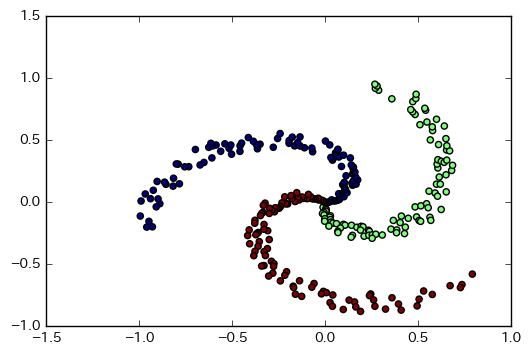

In [2]:
N = 100 # number of samples
M = 3     # number of classes

X = np.zeros((N*M, 2)) # data matrix
y = np.zeros((N*M)) # class labels

phy = 2*np.pi/M

for i in range(M):
    # angle with noise
    t = np.linspace(0, np.pi, num=N) +  np.random.rand(N) * 0.5
   
    # circle
    r = np.linspace(0, 1, N) # radius
    circle = np.array([r*np.cos(t) , r*np.sin(t)])
   
    # rotation
    rotation_matrix = np.array([[np.cos(phy*i), -np.sin(phy*i)],
                                                    [np.sin(phy*i), np.cos(phy*i)]])
    x = np.dot(circle.T, rotation_matrix)
   
    # data と label を 保存
    X[i*N : (i+1)*N] = x
    y[i*N : (i+1)*N] = np.ones(N)*i

# plot
plt.scatter(X[:, 0], X[:, 1], c=y)

３つの色に分かれた螺旋状のデータセットが生成されました。このデータを使って演習を進めていきます。

In [3]:
#データセットXのshapeを確認しましょう。
X.shape

(300, 2)

データセットの正解ラベルを用意します。

正解ラベルは $y$ に格納しています。確認してみましょう。

In [4]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

y に格納された値は $0,1,2$ が並んだ配列になっていると思います。

ここでは、one-hotエンコーティングの形で正解ラベルを用意したいため、正解ラベルのベクトルの成分の１つだけが「１」、それ以外が「０」のベクトルを作りたいと思います。

ここでは単位行列を生成するNumPyの関数 eye() を使います。下のセルを実行してnp.eye()を確認してみましょう。

In [5]:
np.eye(5) #行の数を指定（列の数も指定）

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [6]:
print(np.eye(5)[0])
print(np.eye(5)[1])
print(np.eye(5)[2])
print(np.eye(5)[3])
print(np.eye(5)[4])

[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]


In [7]:
print(np.eye(5)[2, 4])

0.0


In [8]:
print(np.eye(5)[np.array([2, 4])])

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [9]:
np.eye(5,2)  #行と列の数を指定

array([[1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

ただし、このままでは任意の要素に１を立てることができません。

任意の要素に１をおきたい場合は次のように記述します。

In [10]:
test_matrix = np.array([0,3,1,2])
np.eye(4)[test_matrix] 

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

上のセルでは、４クラス分類の例を考え、０から３番目のクラスの任意の位置に１を立て、one-hotエンコーディーングを実装してみました。

下記のコードで「生成したデータセット y」をone-hotエンコーディングします。

In [11]:
#one-hotエンコーディング
y = np.array(y, dtype='uint8').reshape(300,)
n_values = 3 #クラス数
Y = np.eye(n_values)[y]

データセットの shape を確認します。

In [12]:
print ('入力データ X の shape: ' + str(X.shape))
print ('正解ラベル Y の shape: ' + str(Y.shape))

入力データ X の shape: (300, 2)
正解ラベル Y の shape: (300, 3)


入力データ $X$ と正解ラベル $y$ の中身を確認してみましょう。

In [13]:
X[:10]

array([[0.        , 0.        ],
       [0.0099786 , 0.0015678 ],
       [0.02006524, 0.00234682],
       [0.02938587, 0.00739892],
       [0.03456662, 0.02091973],
       [0.04921109, 0.01135909],
       [0.05887009, 0.01440164],
       [0.06821602, 0.01860281],
       [0.07705092, 0.02435369],
       [0.08130388, 0.04067115]])

In [14]:
Y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

$m$ に訓練データの数を格納しておきます。今回は300個のデータセットになります。

In [15]:
m = X.shape[0] 

In [16]:
print ('訓練データの数：%d' %(m))

訓練データの数：300


本演習では、訓練データのみを用います。そのためテストデータはありません。

## ニューラルネットワークモデルの構築

ニューラルネットワークのモデルの構築・学習に取り組みます。

下記の条件で、ニューラルネットワークのモデルを構築します：

- 入力層のニューロン数2個
- 隠れ層のニューロン数100個
- 出力層のニューロン数3個

入力層のニューロン数2個、隱れ層のニューロン数100個、出力層のニューロン数3個とします。

In [17]:
# ニューラルネットワークの構造を決める
input_size = 2
hidden_size = 100
output_size = 3

### パラメータの初期化

各パラメータに設定する値（初期値）を乱数で与えます。

In [18]:
W1 = np.random.randn(input_size,hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size,output_size)
b2 = np.zeros((1, output_size))

各パラメータのシェイプと値を確認してみましょう。

In [19]:
print('W1:', W1.shape)
print('b1:', b1.shape)
print('W2:', W2.shape)
print('b2:', b2.shape)
print('W1:', W1)
print('b1:', b1)
print('W2:', W2)
print('b2:', b2)

W1: (2, 100)
b1: (1, 100)
W2: (100, 3)
b2: (1, 3)
W1: [[-1.36229318  0.81526043 -0.06252164  0.49146501 -0.0443016  -0.73100866
  -0.64538663 -1.3318273   0.4352571   1.38200944  2.07074546 -1.2644918
   0.79252397 -0.25024815 -0.25820616 -0.09440584  0.46968896  0.43845815
   2.3382322   0.46068067  1.73256401 -0.10208782  0.30593927 -0.45564216
  -2.61819136  1.28359629 -0.83663319  0.17625286  0.94218175  1.17253291
   0.32514565  2.50323232 -0.8628334   1.41346679 -0.04544074  0.84338849
   1.61033309 -1.62779851  0.36148185  1.23760783 -1.07830684 -0.67532825
   1.00892023 -1.28973735  1.57704517  0.97839813 -2.27057616  1.30547725
   0.70338983 -1.52116764 -0.35431371 -0.29276281  2.04905804  0.84670715
  -0.20216044 -0.91300243 -1.34577722  0.99004248 -0.56477091  0.50321761
  -0.31260317  1.0964681  -0.48714826 -0.47264082 -0.84192909 -0.67233019
   0.30302498  1.07682917  0.35360167 -0.23357675 -0.52141481 -0.57856303
  -1.40167801  0.12297819 -1.00709244 -0.63820499 -0.549680

## 活性化関数

ニューラルネットワークのモデルで利用する活性化関数を下記のように実装します。

In [20]:
# relu関数
def relu(x):
    return np.maximum(0, x)
    
# relu関数の微分
def relu_derivative(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x
    
def softmax(x):
    c = np.max(x)
    exp_x = np.exp(x - c)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True) 

## ニューラルネットワークのモデル

**Setp8 演習04 （発展課題）マルチクラス問題を解く** で紹介したコードを下のセルに書いています。

まったく同じコードです。変わったのは、**データセット**と**モデルの構造**だけです。

では、実際に学習がうまく進むのか下のセルを実行して確認してみましょう。計算には数秒かかります。

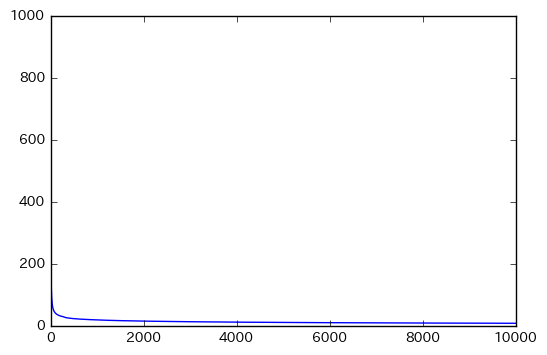

In [21]:
# 初期値設定（乱数で与える）
W1 = np.random.randn(input_size,hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size,output_size)
b2 = np.zeros((1, output_size))

# 学習率
learning_rate = 0.1

# setup parameters for batch operation
epochs = 10000

cost = []
for _ in range(epochs):
    #　フォワードプロパゲーション
    layer1_z = np.dot(X, W1) + b1 
    layer1_a = relu(layer1_z)          # relu activation

    layer2_z = np.dot(layer1_a, W2) + b2
    layer2_a = softmax(layer2_z)       # softmax

    output = layer2_a                  # layer2_a is the output

    # Compute cost (Softmax Cross Entropy)
    cost.append(-np.sum(Y * np.log(output)))

    #　バックプロパゲーション
    delta2 = (output - Y) / 300
    delta_W2 = np.dot(layer1_a.T, delta2) 
    delta_b2 = np.sum(delta2, axis=0 ,keepdims=True)

    delta1 = np.dot(delta2, W2.T) * relu_derivative(layer1_z)
    delta_W1 = np.dot(X.T, delta1) 
    delta_b1 = np.sum(delta1, axis=0 ,keepdims=True)

    # Update Parameters
    W2 = W2 - learning_rate * delta_W2
    b2 = b2 - learning_rate * delta_b2
    W1 = W1 - learning_rate * delta_W1
    b1 = b1 - learning_rate * delta_b1

plt.plot(cost)
plt.show()

## 結果の可視化

/opt/conda/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/opt/conda/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(-1.8786982376343762, 1.9413017623656272)

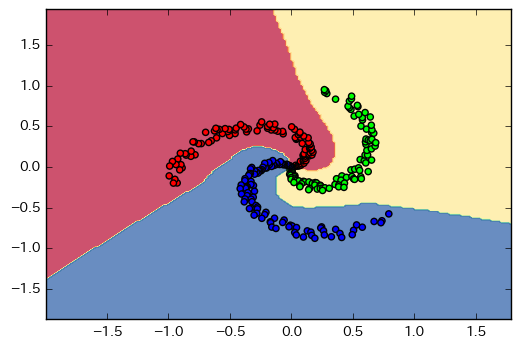

In [22]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## 正解率

In [23]:
# evaluate training set accuracy
layer1_z = np.dot(X, W1) + b1
layer1_a = relu(layer1_z)
layer2_z = np.dot(layer1_a, W2) + b2
layer2_a = softmax(layer2_z)

predicted_class = np.argmax(layer2_a, axis=1)
predicted_class_y_train = np.argmax(Y,axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == predicted_class_y_train)))

training accuracy: 0.99


**【課題１１】** これまで取り扱ったデータセットの違いを踏まえ、ニューラルネットワークのモデルについて考察してください。

In [24]:
#Coursemale-02 Step8 QuestionNumber11 b62c5173d928c9828ce77e5c98a8e7d7
print("この課題の採点は全員正解とします。")

この課題の採点は全員正解とします。


左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [25]:
%%bash
./validation_client.py male-02 8 11 Step8_06.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



## おつかれさまでした

データセットの量・出力クラス数が増えても基本的なニューラルネットワークの実装は Step8 演習04,05で取り組んだこととほとんど変わらなかったと思います。

ニューラルネットワークは扱えるデータによりますが強力な手法の一つです。

以上でStep8の演習は終了となります。

ニューラルネットワークの基礎となるフォワードプロパゲーション、そしてバックプロパゲーションについてゼロから実装し学習してもらいました。

またこれまでのStep８の演習ではライブラリ scikit-learnを使ったニューラルネットワークの実装も体験してもらいました。

本演習では主に線形分離不可能なデータを用いてきましたが、より複雑なデータを学習するためには隠れ層の数を増やしてみたり、ニューロンの数を増やす必要があります。

試行錯誤することはいいこころがけです。

ニューラルネットワークはディープラーニングを学習する上でも大変重要な土台部分になります。

最後に改めてStep全体をもう一度復習し、理解度を高めてください。

機械学習コースの受講、おつかれさまでした。